In [86]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
from matplotlib import rc
plt.style.use('classic')
rc('font', family='serif')
rc('figure', facecolor='w')
from mpl_toolkits.mplot3d import Axes3D
from astropy.io import fits, ascii
from astropy.table import Table
import astropy.units as u
import astropy.coordinates as coord
from astropy.coordinates import ICRS
from collections import OrderedDict
from scipy.interpolate import UnivariateSpline
import os, math, time
from natsort import natsorted as nsort

from galpy.orbit import Orbit
from galpy.potential import MWPotential2014
from galpy.actionAngle import actionAngleSpherical
import TheCannon
from TheCannon import apogee, dataset, model
import apogee_tools as ap
AP_PATH = os.environ['APOGEE_DATA']

line_list = ap.lines
line_names = line_list.keys()

In [22]:
def load_spectra(test_ID, **kwargs):

    data_dir = kwargs.get('dir', os.environ['APOGEE_DATA'] + '/aspcap_data')
    files = [data_dir+'/aspcapStar-r8-l31c.2-'+ID+'.fits' for ID in test_ID]
    
    nstars = len(files)    
    print('Loading', nstars, 'files...')
    
    for jj, fits_file in enumerate(files):
        if not os.path.isfile(fits_file):
            ap.download(test_ID[jj], type='aspcap', dir=data_dir)     
            
        file_in = fits.open(fits_file)
        flux = np.array(file_in[1].data)
        if jj == 0:
            npixels = len(flux)
            fluxes = np.zeros((nstars, npixels), dtype=float)
            ivars = np.zeros(fluxes.shape, dtype=float)
            start_wl = file_in[1].header['CRVAL1']
            diff_wl = file_in[1].header['CDELT1']
            val = diff_wl * (npixels) + start_wl
            wl_full_log = np.arange(start_wl,val, diff_wl)
            wl_full = [10 ** aval for aval in wl_full_log]
            wl = np.array(wl_full)
        flux_err = np.array((file_in[2].data))
        badpix = apogee.get_pixmask(flux, flux_err)
        ivar = np.zeros(npixels)
        ivar[~badpix] = 1. / flux_err[~badpix]**2
        fluxes[jj,:] = flux
        ivars[jj,:] = ivar


    return wl, fluxes, ivars

def chi_sq(data, model, ivar):
    chi = []
    for i in range(len(data)):
        chi.append(np.sum(ivar[i]*(data[i]-model[i])**2))
    return np.array(chi)

def testCannonModel(md, test_ID, tst_dir):
        
    wl, data_flux, data_ivar = load_spectra(test_ID, dir=tst_dir)  
    print(len(test_ID), 'loaded spectra')

    wave = ap.rvShift(wl, rv=-80)
    tst_ds = dataset.Dataset(wave, test_ID, data_flux, data_ivar, None, test_ID, data_flux, data_ivar)
    tst_ds.set_label_names(trn_ds._label_names)   
    print('loaded dataset')
    
    label_errs = md.infer_labels(tst_ds)
    test_labels = tst_ds.test_label_vals
    
    test_flux = ap.labelToSpec(test_labels, md.coeffs)
    print('computed fluxes')
    
    chi = chi_sq(data_flux, test_flux, data_ivar)
    print('computed gof')
    
    return test_labels, test_flux, chi

In [96]:
west_xm = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/raw_data_files/west_x_APOGEE_x_Gaia.csv.gz')
results_w = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/train_west/results/test_results.csv.gz')
no_spec = list(set(west_xm['APOGEE_ID']) - set(results_w['ID']))
for miss_id in no_spec:
    west_xm = west_xm[west_xm['APOGEE_ID'] != miss_id]
ind_w = np.array([np.where(results_w['ID'] == ID)[0][0] for ID in west_xm['APOGEE_ID']])

spt = west_xm['SpT']
bp_rp_w = west_xm['phot_bp_mean_mag'] - west_xm['phot_rp_mean_mag']
g_abs_w = west_xm['phot_g_mean_mag'] + 5*np.log10(west_xm['parallax'])-10

In [138]:
np.array(test.keys())

array(['Unnamed: 0', 'BP_RP', 'CHI_MANN', 'DEC', 'DIST', 'FE_H',
       'GAIA_ID', 'G_ABS', 'H', 'J', 'K', 'PLX', 'PLX_ERR', 'PMDEC',
       'PMDEC_ERR', 'PMRA', 'PMRA_ERR', 'RA', 'RV_GAIA', 'RV_GAIA_ERR',
       'TEFF', 'X', 'Y', 'Z', 'SPT', 'CHI_WEST', 'APOGEE_ID', 'BP_MAG',
       'G_MAG', 'H_ERR', 'J_ERR', 'K_ERR', 'RP_MAG', 'RV_APOGEE',
       'RV_APOGEE_ERR', 'Vx', 'Vy', 'Vz'], dtype=object)

In [5]:
dfile = AP_PATH + '/training_sets/west_sample_cut/'
rfile = '../train_ref/west_ref_labels.csv'  

ids, wl, tr_flux, tr_ivar = apogee.load_spectra(dfile)
tr_ID = np.array([x.split('2-')[1].split('.fits')[0] for x in ids])
tr_label = ap.loadLabels(rfile, lbl_names=['SPT'])
# tr_label = ap.scaleLabels(ap.loadLabels(rfile, lbl_names=['TEFF', 'FE_H']))

wave = ap.rvShift(wl, rv=-80)
trn_ds = dataset.Dataset(wave, tr_ID, tr_flux, tr_ivar, tr_label, tr_ID, tr_flux, tr_ivar)
trn_ds.set_label_names(['SPT'])

md, trn_ds, synth = ap.fitCannonModel(trn_ds)

This is the right version
Loading spectra from directory /home/jess/Desktop/Research/data/apogee_data/training_sets/west_sample_cut/
Spectra loaded
Done training model. 
Inferring Labels


In [140]:
test_dir = '/home/jess/Desktop/Research/data/apogee_data/test_sets/gaia_mdwarfs'
test = pd.read_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/apogee_test/test_results/test_mann.csv.gz')
test_ID = list(test['ID'])
test['X'] = test['X']*10**3
test['Y'] = test['Y']*10**3
test['Z'] = test['Z']*10**3

In [ ]:
test_labels, test_flux, chi = testCannonModel(md, test_ID, test_dir)

In [141]:
test['SPT'] = test_labels.T[0]
test['CHI_WEST'] = chi
# test['INT_SPT'] = np.array([round(x) for x in test['SPT']])

In [149]:
for l in sorted(test.keys()):
    print(l)

APOGEE_ID
BP_MAG
BP_RP
CHI_MANN
CHI_WEST
DEC
DIST
FE_H
GAIA_ID
G_ABS
G_MAG
H
H_ERR
J
J_ERR
K
K_ERR
PLX
PLX_ERR
PMDEC
PMDEC_ERR
PMRA
PMRA_ERR
RA
RP_MAG
RV_APOGEE
RV_APOGEE_ERR
RV_GAIA
RV_GAIA_ERR
SPT
TEFF
Vx
Vy
Vz
X
Y
Z


In [142]:
gaia_xmatch = fits.open('/home/jess/Desktop/Research/data/apogee_data/apogee_x_gaiadr2_full_info.fits')

gaia = pd.DataFrame({'ID':np.array(gaia_xmatch[1].data['APOGEE_ID_1']).byteswap().newbyteorder(), \
                     'APOGEE_ID':np.array(gaia_xmatch[1].data['APOGEE_ID_1']).byteswap().newbyteorder(), \
                     'RV_APOGEE':np.array(gaia_xmatch[1].data['VHELIO_AVG']).byteswap().newbyteorder(), \
                     'RV_APOGEE_ERR':np.array(gaia_xmatch[1].data['VERR']).byteswap().newbyteorder(), \
                     'G_MAG':np.array(gaia_xmatch[1].data['phot_g_mean_mag']).byteswap().newbyteorder(), \
                     'BP_MAG':np.array(gaia_xmatch[1].data['phot_bp_mean_mag']).byteswap().newbyteorder(), \
                     'RP_MAG':np.array(gaia_xmatch[1].data['phot_rp_mean_mag']).byteswap().newbyteorder(), \
                     'J_ERR':np.array(gaia_xmatch[1].data['J_ERR']).byteswap().newbyteorder(), \
                     'H_ERR':np.array(gaia_xmatch[1].data['H_ERR']).byteswap().newbyteorder(), \
                     'K_ERR':np.array(gaia_xmatch[1].data['K_ERR']).byteswap().newbyteorder()})
test = test.set_index('ID').join(gaia.set_index('ID'))
test = test.drop(['Unnamed: 0'], axis=1)

icrs = ICRS(ra=np.array(test['RA'])*u.degree, dec=np.array(test['DEC'])*u.degree, \
            distance=np.array(test['DIST'])*u.pc, radial_velocity=np.array(test['RV_APOGEE'])*u.km/u.s, \
            pm_ra_cosdec=np.array(test['PMRA'])*u.mas/u.yr, pm_dec=np.array(test['PMDEC'])*u.mas/u.yr)
gc = icrs.transform_to(coord.Galactocentric)

test.rename(columns={'RV': 'RV_GAIA'}, inplace=True)
test.rename(columns={'RV_ERR': 'RV_GAIA_ERR'}, inplace=True)
test.rename(columns={'CHI': 'CHI_MANN'}, inplace=True)
test.rename(columns={'APOGEE_ID': 'ID'}, inplace=True)

test['Vx'] = np.array(gc.v_x)
test['Vy'] = np.array(gc.v_y)
test['Vz'] = np.array(gc.v_z)

In [148]:
test['APOGEE_ID'] = test['ID']
test = test.drop(['ID'], axis=1)
test.to_csv('/home/jess/Desktop/Research/Mdwarf_project/cannon_runs/apogee_test/test_results/test_mann_and_west.csv', \
           index=False)

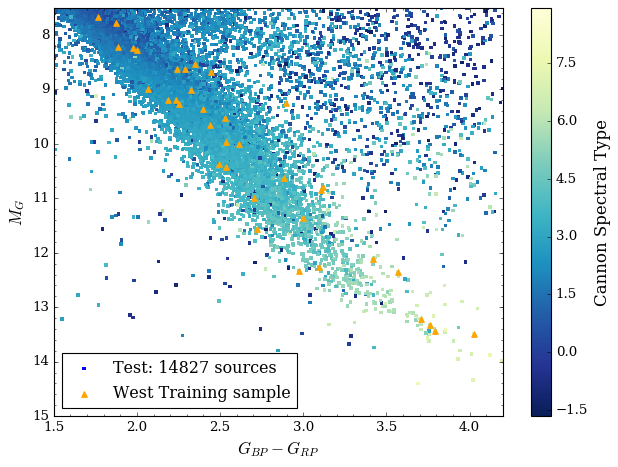

In [97]:
pl = plt.scatter(test['BP_RP'], test['G_ABS'], c=test['SPT'], cmap='YlGnBu_r', edgecolor='none', s=10, marker='s', \
                 label='Test: %s sources'%(len(test)))
plt.scatter(bp_rp_w, g_abs_w, color='orange', marker='^', label='West Training sample', s=25)
cb = plt.colorbar(pl)
cb.set_label(r'Cannon Spectral Type', fontsize=15)
plt.xlabel(r'$G_{BP} - G_{RP}$', fontsize=15)
plt.ylabel(r'$M_{G}$', fontsize=15)
plt.ylim(15,7.5)
plt.xlim(1.5,4.2)
# plt.title('West-trained SPT Model')
plt.legend(loc='lower left', scatterpoints=1)
plt.minorticks_on()
plt.tight_layout()
plt.show()

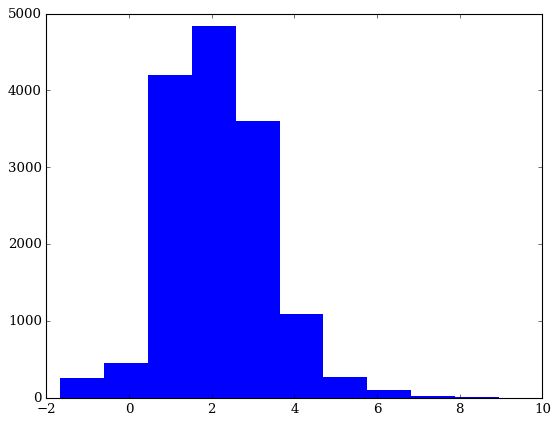

In [115]:
plt.hist(test['SPT'], edgecolor='none')
plt.show()

In [119]:
len(test)

14827

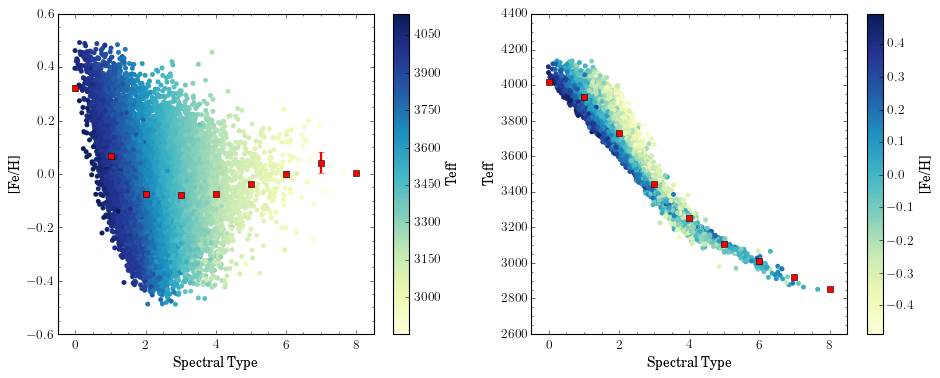

In [11]:
subtypes = list(set(test['INT_SPT']))
mean_feh, std_feh = [], []
mean_teff, std_teff = [], []

for sub in subtypes:
    sub_test = test[test['INT_SPT'] == sub]
    N = len(sub_test)
    mean_feh.append(np.mean(sub_test['FE_H']))
    std_feh.append(np.std(sub_test['FE_H'])/math.sqrt(N))
    mean_teff.append(np.mean(sub_test['TEFF']))
    std_teff.append(np.std(sub_test['TEFF'])/math.sqrt(N))

fig, (ax1, ax2) = plt.subplots(1,2, figsize=[14,5])
pl1 = ax1.scatter(test['SPT'], test['FE_H'], edgecolor='none', c=test['TEFF'], cmap='YlGnBu')
ax1.errorbar(subtypes, mean_feh, yerr=std_feh, color='r', linewidth=2, fmt='s')
plt.colorbar(pl1, ax=ax1).set_label('Teff')
ax1.set_xlim(-.5,8.5)
ax1.set_xlabel('Spectral Type')
ax1.set_ylabel('[Fe/H]')
ax1.minorticks_on()

pl2 = ax2.scatter(test['SPT'], test['TEFF'], edgecolor='none', c=test['FE_H'], cmap='YlGnBu')
ax2.errorbar(subtypes, mean_teff, yerr=std_teff, color='r', linewidth=2, fmt='s')
plt.colorbar(pl2, ax=ax2).set_label('[Fe/H]')
ax2.set_xlim(-.5,8.5)
ax2.set_xlabel('Spectral Type')
ax2.set_ylabel('Teff')
ax2.minorticks_on()
plt.show()

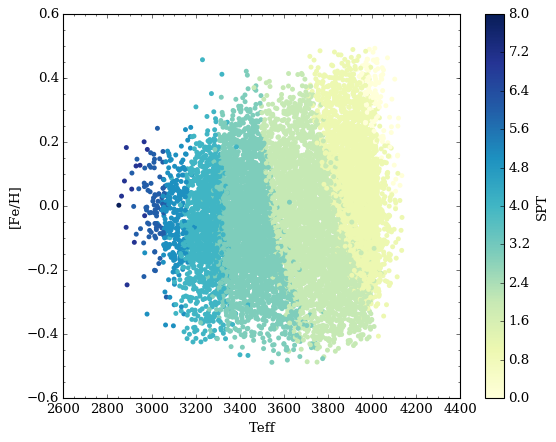

In [31]:
plt.scatter(test['TEFF'], test['FE_H'], c=test['INT_SPT'], edgecolor='none', cmap='YlGnBu')
plt.xlabel('Teff')
plt.ylabel('[Fe/H]')
cb = plt.colorbar()
cb.set_label('SPT')
plt.minorticks_on()
plt.show()

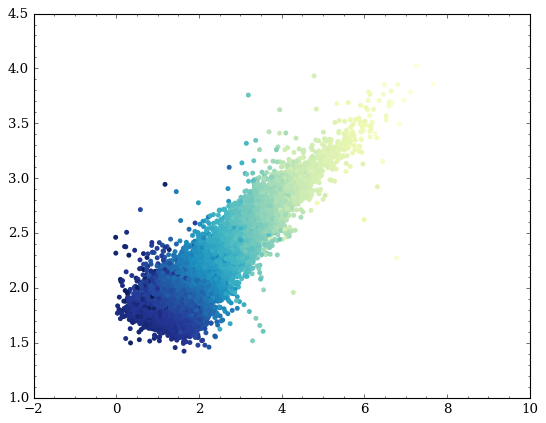

In [30]:
plt.scatter(test['SPT'], test['BP_RP'], c=test['TEFF'], edgecolor='none', cmap='YlGnBu')
plt.minorticks_on()
plt.show()

In [13]:
aA = actionAngleSpherical(pot=MWPotential2014)

actions = []
integrable, nonintegrable = [], []
for i in range(len(test)):
    try:
        orb = Orbit(vxvv=[test['RA'][i], test['DEC'][i], test['DIST'][i], test['PMRA'][i], \
                          test['PMDEC'][i], test['VHELIO_AVG'][i]], radec=True, ro=8., vo=220.)
        actions.append(list(aA(orb)))
        integrable.append(i)
    except:
        nonintegrable.append(i)

In [14]:
len(integrable), len(actions), len(actions.T[0])

AttributeError: 'list' object has no attribute 'T'

In [15]:
act = test.iloc[integrable]
actions = np.array(actions)
act['Jr'] = np.array(actions.T[0][0])
act['Jp'] = np.array(actions.T[0][1])
act['Jz'] = np.array(actions.T[0][2])

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

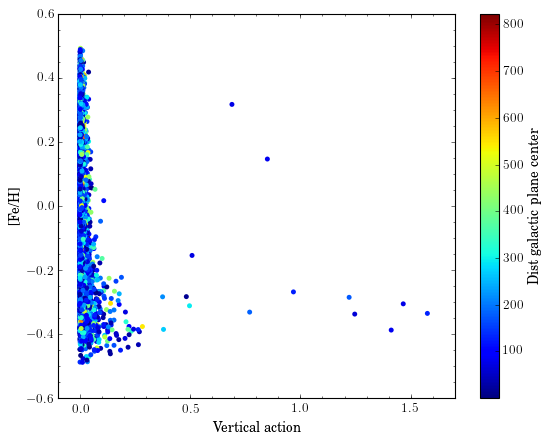

In [16]:
# bsize = .2

# zbin, nbin = [], []
# mean_feh, std_feh = [], []

# for z in np.arange(0, 2, bsize):
#     binz = [z, z+bsize]
    
#     bin_test = act
#     bin_test['Jz'] = np.abs(bin_test['Jz'])
#     bin_test = bin_test[(bin_test['Jz'] > binz[0]) & (bin_test['Jz'] < binz[1])]
    
#     N = len(bin_test)
#     if N != 0:
#         zbin.append(np.mean(binz))
#         nbin.append(len(bin_test))
#         mean_feh.append(np.mean(bin_test['FE_H']))
#         std_feh.append(np.std(bin_test['FE_H'])/math.sqrt(N))

#======
plt.scatter(act['Jz'], act['FE_H'], c=np.abs(act['Z']), edgecolor='none')
# plt.errorbar(zbin, mean_feh, yerr=std_feh, color='r')
plt.colorbar().set_label('Dist galactic plane center')
plt.xlabel('Vertical action')
plt.ylabel('[Fe/H]')
plt.xlim(-.1,1.7)
plt.minorticks_on()
plt.show()

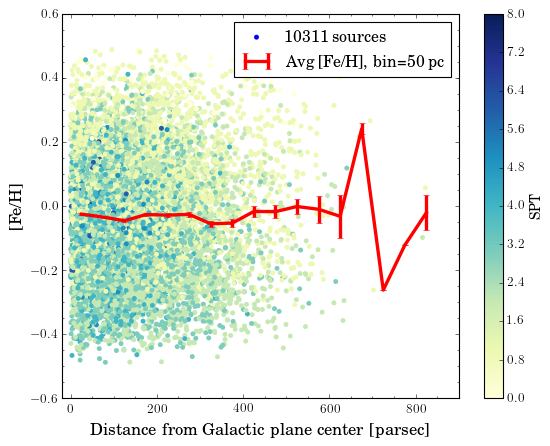

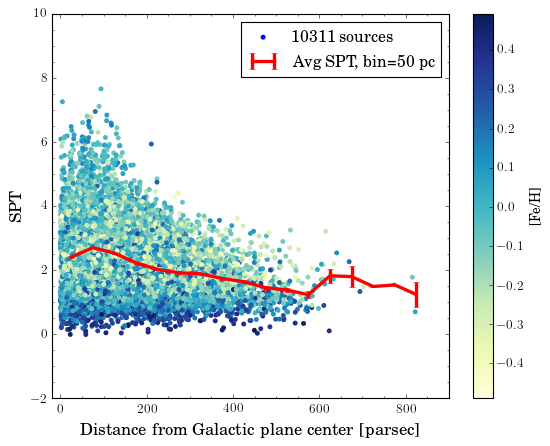

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



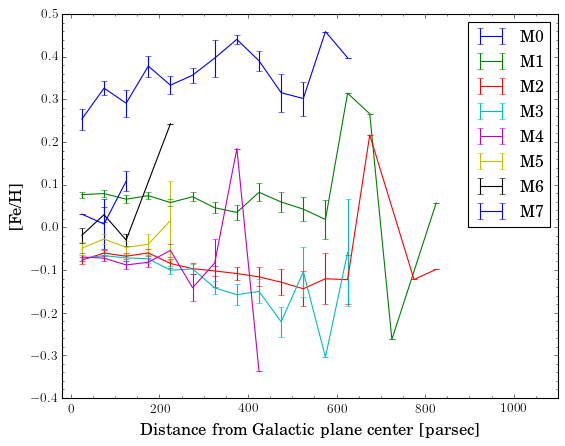

In [17]:
bsize = 50

zbin, nbin = [], []
mean_feh, std_feh = [], []
mean_spt, std_spt = [], []

for z in np.arange(0, 1000, bsize):
    binz = [z, z+bsize]
    
    bin_test = test
    bin_test['Z'] = np.abs(bin_test['Z'])
    bin_test = bin_test[(bin_test['Z'] > binz[0]) & (bin_test['Z'] < binz[1])]
    
    N = len(bin_test)
    if N != 0:
        zbin.append(np.mean(binz))
        nbin.append(len(bin_test))
        mean_feh.append(np.mean(bin_test['FE_H']))
        std_feh.append(np.std(bin_test['FE_H'])/math.sqrt(N))

        mean_spt.append(np.mean(bin_test['SPT']))
        std_spt.append(np.std(bin_test['SPT'])/math.sqrt(N))
    
pl = plt.scatter(np.abs(test['Z']), test['FE_H'], edgecolor='none', c=test['INT_SPT'], cmap='YlGnBu', label='%s sources'%(len(test)))
plt.errorbar(zbin, mean_feh, yerr=std_feh, color='r', linewidth=3, label='Avg [Fe/H], bin=%s pc'%(50))
plt.colorbar(pl).set_label('SPT')
plt.xlabel('Distance from Galactic plane center [parsec]', fontsize=15)
plt.ylabel('[Fe/H]', fontsize=15)
plt.xlim(-20,900)
plt.legend(loc='upper right', scatterpoints=1)
plt.minorticks_on()
plt.show()

#=======
# fig, (ax1, ax2) = plt.subplots(1,2, figsize=[12,4], sharex=True, sharey=True)
pl = plt.scatter(np.abs(test['Z']), test['SPT'], edgecolor='none', c=test['FE_H'], cmap='YlGnBu', label='%s sources'%(len(test)))
plt.errorbar(zbin, mean_spt, yerr=std_spt, color='r', linewidth=3, label='Avg SPT, bin=%s pc'%(50))
plt.colorbar(pl).set_label('[Fe/H]')
plt.xlabel('Distance from Galactic plane center [parsec]', fontsize=15)
plt.ylabel('SPT', fontsize=15)
plt.xlim(-20,900)
plt.legend(loc='upper right', scatterpoints=1)
plt.minorticks_on()
plt.show()

#=======
for spt in np.arange(0,8):
    zbin, nbin = [], []
    mean_feh, std_feh = [], []

    for z in np.arange(0, 1000, bsize):
        binz = [z, z+bsize]

        bin_test = test[test['INT_SPT'] == spt]
        bin_test['Z'] = np.abs(bin_test['Z'])
        bin_test = bin_test[(bin_test['Z'] > binz[0]) & (bin_test['Z'] < binz[1])]

        N = len(bin_test)
        if N != 0:
            zbin.append(np.mean(binz))
            nbin.append(len(bin_test))
            mean_feh.append(np.mean(bin_test['FE_H']))
            std_feh.append(np.std(bin_test['FE_H'])/math.sqrt(N))
    plt.errorbar(zbin, mean_feh, yerr=std_feh, label='M%s'%(spt))
plt.xlabel('Distance from Galactic plane center [parsec]', fontsize=15)
plt.ylabel('[Fe/H]', fontsize=15)
plt.xlim(-20,1100)
plt.legend(loc='upper right', scatterpoints=1)
plt.minorticks_on()
plt.show()


In [ ]:
bsize = 50

zbin, nbin = [], []
mean_vx, dis_vx = [], []
mean_vy, dis_vy = [], []
mean_vz, dis_vz = [], []

for z in np.arange(0, 1000, bsize):
    binz = [z, z+bsize]
    
    bin_test = test
    bin_test['Z'] = np.abs(bin_test['Z'])
    bin_test = bin_test[(bin_test['Z'] > binz[0]) & (bin_test['Z'] < binz[1])]
    
    N = len(bin_test)
    zbin.append(np.mean(binz))
    nbin.append(N)
    
    mean_vx.append(np.mean(bin_test['v_x']))
    dis_vx.append(np.std(bin_test['v_x']))
    
    mean_vy.append(np.mean(bin_test['v_y']))
    dis_vy.append(np.std(bin_test['v_y']))

    mean_vz.append(np.mean(bin_test['v_z']))
    dis_vz.append(np.std(bin_test['v_z']))
    
# plt.errorbar(zbin, mean_vx, yerr=std_vx)
# plt.xlabel('Distance from Galactic plane center [parsec]', fontsize=15)
# plt.ylabel('<Vx>', fontsize=15)
# plt.show()

# #=======
# plt.errorbar(zbin, mean_vy, yerr=std_vy)
# plt.xlabel('Distance from Galactic plane center [parsec]', fontsize=15)
# plt.ylabel('<Vy>', fontsize=15)
# plt.show()

# #=======
# plt.errorbar(zbin, mean_vz, yerr=std_vz)
# plt.xlabel('Distance from Galactic plane center [parsec]', fontsize=15)
# plt.ylabel('<Vz>', fontsize=15)
# plt.show()

In [18]:
test.keys()

Index(['Unnamed: 0', 'BP_RP', 'CHI', 'DEC', 'DIST', 'FE_H', 'GAIA_ID', 'G_ABS',
       'H', 'J', 'K', 'PLX', 'PLX_ERR', 'PMDEC', 'PMDEC_ERR', 'PMRA',
       'PMRA_ERR', 'RA', 'RV', 'RV_ERR', 'TEFF', 'X', 'Y', 'Z', 'K_ABS', 'J_K',
       'line1', 'line2', 'SPT', 'INT_SPT', 'VHELIO_AVG', 'v_x', 'v_y', 'v_z'],
      dtype='object')

In [19]:
test['ID']

KeyError: 'ID'